In [26]:
#import argparse
import os
import deepchem as dc
from deepchem.utils.data_utils import load_from_disk, save_to_disk
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import GridSearchCV
import multiprocessing
import time
import matplotlib.pyplot as plt

In [27]:
TRAIN = "../data/smiles_all_property.csv"
TARGET_COL = "wavelength"
SMILES_COL = "smiles"
PROPERTY = TARGET_COL


if TARGET_COL == "Decomposition Energy":
    PROPERTY = "Decomposition_Energy"
elif TARGET_COL == "HOMO/LUMO gap":
    PROPERTY = "HOMOLUMO_gap"

MODEL_DIR = "../model/" + PROPERTY
LOG_DIR = "../log/" + PROPERTY

DATA_DIR = "../data/" + PROPERTY

DATA_EXIST = os.path.exists(DATA_DIR + "/tasks.json")

In [28]:
DATA_EXIST

True

In [4]:
def model_builder(**model_params):
    estimator = LGBMRegressor()
    estimator.set_params(**model_params)
    return dc.models.SklearnModel(estimator)

In [5]:
featurizer = dc.feat.RDKitDescriptors()

In [6]:
# 学習データの読み込み
loader = dc.data.CSVLoader(tasks=[TARGET_COL],
                            feature_field=SMILES_COL,
                            featurizer=featurizer)

CSVファイル形式の場合は、以下を実行してDATA_DIRにDiskDataset形式で保存

10分ほど時間がかかる

DATA_DIRにDiskDataset形式で保存している場合は、以下を実行

一瞬で実行可能

In [8]:
if DATA_EXIST == True:
    dataset = dc.data.DiskDataset(DATA_DIR)
else:
    dataset = loader.create_dataset(TRAIN, data_dir=DATA_DIR)

In [9]:
splitter = dc.splits.IndexSplitter()

In [10]:
train_dataset, valid_dataset, test_dataset = splitter.train_valid_test_split(dataset, frac_train=0.6, frac_valid=0.2, frac_test=0.2)

In [11]:
transformers = [dc.trans.NormalizationTransformer(transform_y=True,dataset=train_dataset)]

In [12]:
for transformer in transformers:
    train_dataset = transformer.transform(train_dataset)
    valid_dataset = transformer.transform(valid_dataset)
    #test_dataset = transformer.transform(test_dataset)

In [13]:
print(train_dataset.X.shape)
print(valid_dataset.X.shape)
print(test_dataset.X.shape)

(52576, 209)
(17526, 209)
(17526, 209)


In [14]:
print(dataset)
print(train_dataset)

<DiskDataset X.shape: (87628, 209), y.shape: (87628, 1), w.shape: (87628, 1), task_names: ['wavelength']>
<DiskDataset X.shape: (52576, 209), y.shape: (52576, 1), w.shape: (52576, 1), task_names: ['wavelength']>


In [15]:
import multiprocessing
multiprocessing.cpu_count()

256

In [16]:
metric = dc.metrics.Metric(dc.metrics.mean_absolute_error)
optimizer = dc.hyper.GridHyperparamOpt(model_builder)

params_dict = {
        #'boosting_type': ['rf'],
        'num_leaves': [100],
        'criterion': ['absolute_error'],
        'max_depth': [200],
        'min_child_samples': [30],
        'learning_rate': [0.01],
        'n_estimators': [40000],
        'reg_lambda': [0],
        'colsample_bytree': [0.4],
        'n_jobs': [multiprocessing.cpu_count()],
        }

In [17]:
'''
estimator = LGBMRegressor()

tuned_model = GridSearchCV(estimator=estimator, 
                           param_grid=params_dict, 
                           return_train_score=False)
'''

'\nestimator = LGBMRegressor()\n\ntuned_model = GridSearchCV(estimator=estimator, \n                           param_grid=params_dict, \n                           return_train_score=False)\n'

In [18]:
#tuned_model.fit(train_dataset, valid_dataset)

In [19]:
import time

ut = time.time()
print(ut)

1703422220.8010607


In [20]:
best_model, best_model_hyperparams, all_model_results = optimizer.hyperparam_search(params_dict=params_dict, 
                                                                                    train_dataset=train_dataset, 
                                                                                    valid_dataset=valid_dataset, 
                                                                                    output_transformers=transformers, 
                                                                                    metric=metric, 
                                                                                    use_max=False)

[LightGBM] [Warning] Unknown parameter: criterion
[LightGBM] [Warning] Unknown parameter: model_dir


In [21]:
# モデルの保存
save_to_disk(best_model, MODEL_DIR + "/model.joblib")

In [22]:
# モデルのロード
loaded_model = load_from_disk(MODEL_DIR + "/model.joblib")

6.45861595403403


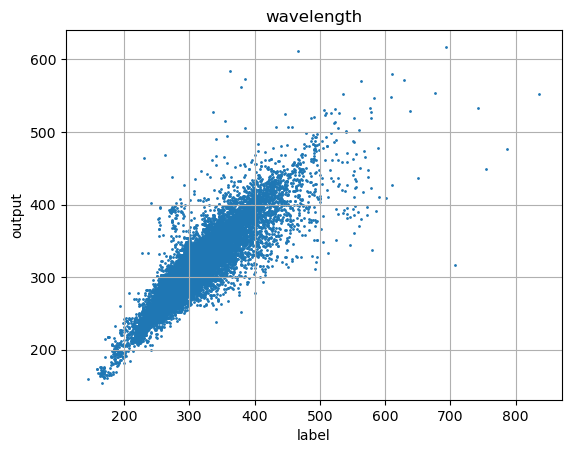

In [24]:
import matplotlib.pyplot as plt
import time

%matplotlib inline


time_sta = time.perf_counter()
predicted_test = loaded_model.predict(test_dataset, transformers=transformers)
time_end = time.perf_counter()


tim = time_end- time_sta
print(tim)


true_test = test_dataset.y


plt.scatter(true_test, predicted_test, s=1)
plt.xlabel('label')
plt.ylabel('output')
plt.title(TARGET_COL)
plt.grid(True)
plt.savefig("../scatter/" + PROPERTY + "/scatter.png")

In [25]:
dc.metrics.mean_absolute_error(true_test, predicted_test)

16.474767112974362

In [37]:
print(best_model_hyperparams)

{'num_leaves': 100, 'criterion': 'absolute_error', 'max_depth': 200, 'min_child_samples': 30, 'learning_rate': 0.01, 'n_estimators': 40000, 'reg_lambda': 0, 'colsample_bytree': 0.4, 'n_jobs': 256}


In [39]:
all_model_results

{'_colsample_bytree_0.400000_criterionabsolute_error_learning_rate_0.010000_max_depth_200_min_child_samples_30_n_estimators_40000_n_jobs_256_num_leaves_100_reg_lambda_0': 15.257990817374827}